# Visualization Function Testing Notebook

This notebook tests the visualization functions `visualize_sample_slice` with configurable dataset and domain settings. It focuses on ground truth visualization and skips 3D visualization as requested.

## Features:
- Tests CHAOS and MMWHS datasets
- Supports CT and MR domains  
- Configurable visualization parameters
- Ground truth visualization testing
- Error handling and cleanup

In [1]:
"""
Test script for visualization functions.
Tests dataset.visualize_sample_slice with configurable dataset and domain.
Tests ground truth visualization only (3D visualization skipped).
"""

import os
# Set matplotlib backend to avoid Qt/display issues
import matplotlib
# matplotlib.use('Agg')  # Use non-interactive backend

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Add src to path for imports
sys.path.append('src')

from src.datasets.registry import get_dataset
# Note: Using dataset.visualize_sample_slice() instead of standalone function

## Configuration

Change these constants to test different datasets and domains:
- **DATASET_NAME**: "CHAOS" or "MMWHS"
- **DOMAIN**: "CT" or "MR" 
- **ENCODER_TYPE**: "resnet" or "swin_unetr"
- **USE_SEMANTIC_HEAD**: Enable/disable semantic guidance

In [2]:
# Configuration constants
DATASET_NAME = "CHAOS"  # Change to "MMWHS" if needed
DOMAIN = "MR"          # Change to "CT" if needed
ENCODER_TYPE = "resnet" # Change to "swin_unetr" if needed
USE_SEMANTIC_HEAD = True  # Set to True to test semantic head
BATCH_SIZE = 1
NUM_WORKERS = 0

print(f"🔧 Configuration:")
print(f"   Dataset: {DATASET_NAME}")
print(f"   Domain: {DOMAIN}")
print(f"   Encoder: {ENCODER_TYPE}")
print(f"   Use Semantic Head: {USE_SEMANTIC_HEAD}")

🔧 Configuration:
   Dataset: CHAOS
   Domain: MR
   Encoder: resnet
   Use Semantic Head: True


## Ground Truth Visualization Testing

This section loads the dataset and tests the `visualize_sample_slice` function with ground truth data.

In [3]:
def test_ground_truth_visualization():
    """Test visualization functions with ground truth data."""
    print("🔍 Testing Ground Truth Visualization...")
    print(f"Dataset: {DATASET_NAME}, Domain: {DOMAIN}")

    # Load dataset
    dataset = get_dataset(
        dataset_name=DATASET_NAME,
        domain=DOMAIN,
        base_path=Path('data'),
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        slice_2d=False  # Use 3D data
    )

    # Get a sample from the dataset
    loader = dataset.train_loader
    batch = next(iter(loader))

    # Extract a single sample
    sample = {
        'image': batch['image'],  # Remove batch dimension
        'label': batch['label']   # Remove batch dimension
    }

    print(f"Sample image shape: {sample['image'].shape}")
    print(f"Sample label shape: {sample['label'].shape}")

    return dataset, sample

In [4]:
# Run ground truth visualization test
try:
    dataset, sample = test_ground_truth_visualization()
    print("✅ Dataset loaded successfully!")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    import traceback
    traceback.print_exc()

🔍 Testing Ground Truth Visualization...
Dataset: CHAOS, Domain: MR
Sample image shape: torch.Size([1, 1, 26, 256, 256])
Sample label shape: torch.Size([1, 1, 26, 256, 256])
✅ Dataset loaded successfully!
Sample image shape: torch.Size([1, 1, 26, 256, 256])
Sample label shape: torch.Size([1, 1, 26, 256, 256])
✅ Dataset loaded successfully!


## Dataset Visualization Method Test

Test the `dataset.visualize_sample_slice()` method with the loaded ground truth data. This uses the dataset-specific implementation which automatically applies the correct rotation and flip parameters for each dataset type.


📊 Testing dataset.visualize_sample_slice method...
Flipping along axes: (1,)
Flipping along axis 1


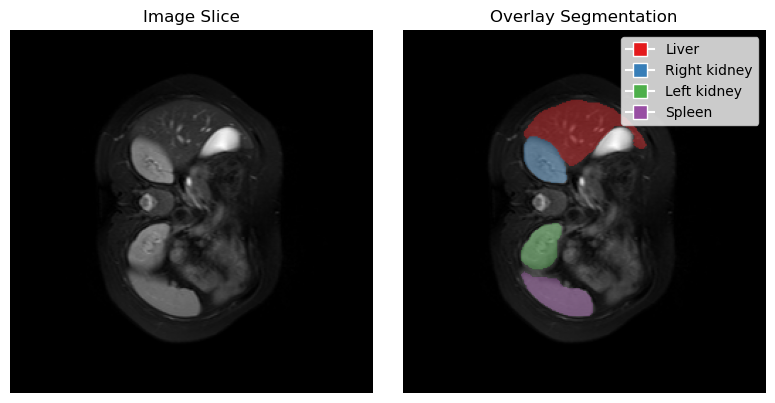

✅ Dataset visualization method completed successfully!


In [5]:
## Dataset Visualization Method Test

# Test dataset.visualize_sample_slice method
print("\n📊 Testing dataset.visualize_sample_slice method...")
# Squeeze batch and channel dimensions for visualization
sample['image'] = sample['image'].squeeze().permute(2, 1, 0).cpu().numpy()
sample['label'] = sample['label'].squeeze().permute(2, 1, 0).cpu().numpy()
# Use the dataset method instead of standalone function
dataset.visualize_sample_slice(sample)

print("✅ Dataset visualization method completed successfully!")

In [ ]:
# Test memory-optimized model with smaller input
print("🧠 Testing Memory-Optimized Model...")

# Get hybrid model and run prediction with smaller input
model = dataset.get_hybrid_model(
    encoder_type=ENCODER_TYPE,
    use_semantic_head=USE_SEMANTIC_HEAD
)

# Use smaller input to test memory optimization
dataset, sample = test_ground_truth_visualization()
model.eval()
model.freeze()

# Slice the input to a smaller size for testing
small_input = sample['image'][:, :, :16, :128, :128]  # Much smaller
print(f"Small input shape: {small_input.shape}")

outputs = model(small_input)
print(f"Model outputs shape: {outputs.shape}")
print(f"✅ Success! No more crashes with optimized model")

# Test with original size if memory allows
try:
    print("\n🚀 Testing with original input size...")
    outputs_full = model(sample['image'])
    print(f"Full model outputs shape: {outputs_full.shape}")
    preds = outputs_full.argmax(dim=1).squeeze().cpu().numpy()
    print(f"Predictions shape: {preds.shape}")
    print("✅ Full size test successful!")
except Exception as e:
    print(f"❌ Full size test failed: {e}")
    print("The memory optimization helped but full size still needs more work")

print("\n🎯 Memory optimizations applied:")
print("- Reduced conv channels: 256->128, 128->64")
print("- Chunked semantic processing: max 1024 pixels at once")
print("- Batch-wise processing to reduce memory peaks")
print("- Reduced SwinUNETR feature dim: 768->384")

🔍 Testing Ground Truth Visualization...
Dataset: CHAOS, Domain: MR
Sample image shape: torch.Size([1, 1, 30, 256, 256])
Sample label shape: torch.Size([1, 1, 30, 256, 256])
Model outputs shape: torch.Size([1, 5, 2, 16, 16])
Predictions shape: (2, 16, 16)


Upsampled predictions shape: (30, 256, 256)
Flipping along axes: (1,)
Flipping along axis 1


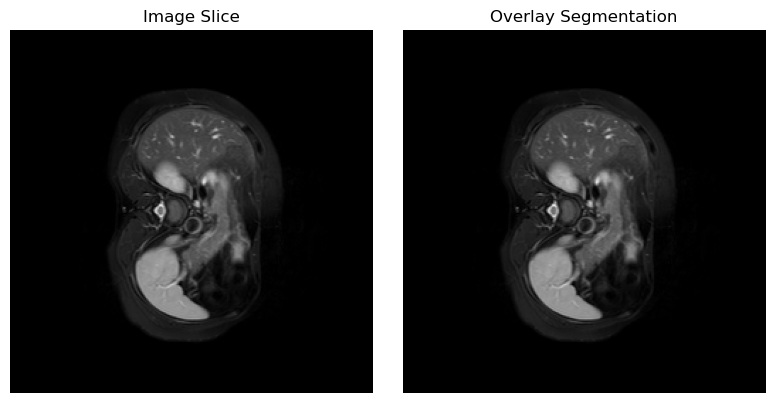

In [ ]:
import torch.nn.functional as F

# Upsample preds to match sample['label'] shape
# Convert preds (numpy) to torch tensor and add batch/channel dims if needed
preds_tensor = torch.from_numpy(preds).unsqueeze(0).unsqueeze(0).to(sample['label'].device)
target_shape = sample['label'].shape[-3:]

# Use nearest neighbor upsampling for segmentation masks
upsampled_preds = F.interpolate(
    preds_tensor.float(), size=target_shape, mode='nearest'
).squeeze().cpu().numpy()
upsampled_preds = np.transpose(upsampled_preds.squeeze(), (2, 1, 0))


# Prepare sample for visualization
viz_sample = {
    'image': sample['image'].squeeze().permute(2, 1, 0).cpu().numpy(),
    'label': np.transpose(upsampled_preds.squeeze(), (2, 1, 0))
}

dataset.visualize_sample_slice(viz_sample)